# Code to generate Figure 1 

In [1]:
from analysis.utils import select_experiment, select_run, GlobalPlotter
import mlflow
from mlflow.tracking import MlflowClient
import xarray as xr
from dask.diagnostics import ProgressBar
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import norm

import cmocean
cmap_solar = cmocean.cm.solar
cmap_balance = cmocean.cm.balance

plt.rcParams["figure.figsize"] = (4, 4 / 1.618)

## Script parameters

In [46]:
# run_control_id = 'a06e42d44402481eb3a8f9e705770950'
# run_1pct_id = '32ebeb9bdec9441ca761e91b8777acd1'
run_control_id = None
run_1pct_id = None
var_name = 'vsurf'
cmap = cmocean.cm.amp


In [5]:
def select_run_id():
    exp_name = select_experiment()
    experiment_id = mlflow.get_experiment_by_name(exp_name).experiment_id
    cols = ['params.CO2', 'params.factor']
    run = select_run(cols=cols, experiment_ids=(experiment_id,))
    return run.run_id

/home/ag7531/miniconda3/envs/analysis/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
ml_client = MlflowClient()
if not run_control_id:
    run_control_id = select_run_id()
if not run_1pct_id:
    run_1pct_id = select_run_id()

run_control = mlflow.get_run(run_control_id)
run_1pct = mlflow.get_run(run_1pct_id)

data_control = xr.open_zarr(ml_client.download_artifacts(run_control_id, 'forcing'))
data_1pct = xr.open_zarr(ml_client.download_artifacts(run_1pct_id, 'forcing'))
data_control = data_control.rename(dict(xu_ocean='longitude', yu_ocean='latitude'))
data_1pct = data_1pct.rename(dict(xu_ocean='longitude', yu_ocean='latitude'))

# Rescale the forcing
for var in ('S_x', 'S_y'):
    data_control[var] /= 1e-7
    data_1pct[var] /= 1e-7

# Remove the seasonal means
seasonal_groupby_control = data_control.groupby('time.month').mean()
seasonal_groupby_1pct = data_1pct.groupby('time.month').mean()

data_control = data_control.groupby('time.month') - seasonal_groupby_control
data_1pct = data_1pct.groupby('time.month') - seasonal_groupby_1pct

6 :  multiregion
17 :  meeting22july
15 :  datacm21
3 :  multiregions
19 :  data-global
14 :  forcingdatav3
2 :  training
4 :  default
7 :  Unet
18 :  forcing-data-global
12 :  test
9 :  forcingdata1pct
5 :  regionsfortraining
20 :  test_global
8 :  arctan
16 :  meeting15july
13 :  forcingdatav2
Select the id of an experiment: 19
                              run_id experiment_id params.CO2 params.factor
0   359a13e63c9744d18336a7b04380569f            19          1             8
1   7a60369c9d5b48058366adef1df59728            19          1             7
2   b85d663b7a1f4e59b09b0d3813cbcab8            19          1             6
3   0c1de3ebefec40748311812a482a8024            19          1             5
4   a5049bd09c7e409791944731e5631a10            19          0             8
5   8f038ef65bdb4667a815029ccf8be3c4            19          0             7
6   2ebecb60c35642fbb1b60d1f6d33df2d            19          0             6
7   1dad89889fae43e798d8fbb171627ad0            19          

In [47]:
var_control = data_control[var_name].std(dim='time')
var_1pct = data_1pct[var_name].std(dim='time')
with ProgressBar():
    var_control = var_control.compute()
    var_1pct = var_1pct.compute()

[###                                     ] | 8% Completed | 30.9s

/home/ag7531/miniconda3/envs/analysis/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[########################################] | 100% Completed |  6min  1.1s
[###                                     ] | 8% Completed | 25.5s

/home/ag7531/miniconda3/envs/analysis/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[########################################] | 100% Completed |  5min 21.6s


In [48]:
diff =  var_1pct - var_control
r_diff = diff / var_control

/home/ag7531/miniconda3/envs/analysis/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Using cached version!
Using cached version!


<IPython.core.display.Javascript object>


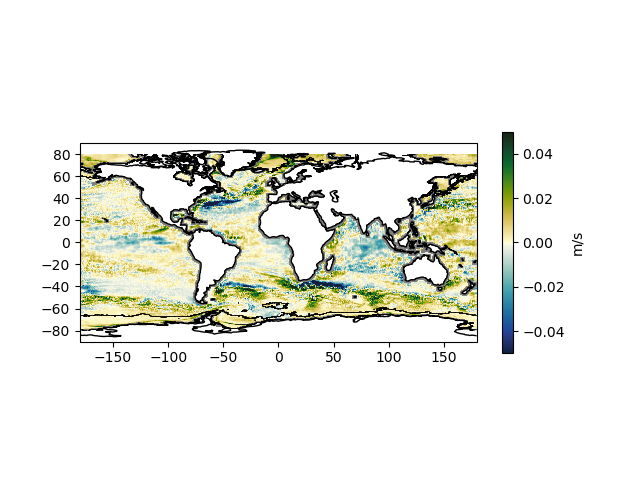

Using cached version!
Using cached version!


In [49]:
%matplotlib notebook
from cartopy.crs import PlateCarree
from data.pangeo_catalog import get_patch, get_whole_data
from scipy.ndimage import gaussian_filter
from matplotlib import colors


CATALOG_URL = 'https://raw.githubusercontent.com/pangeo-data/pangeo-datastore\
/master/intake-catalogs/master.yaml'


plotter = GlobalPlotter(cbar=True, margin=4)
plotter.x_ticks = np.arange(-150., 151., 50)
plotter.y_ticks = np.arange(-80., 81., 20)

ax=plotter.plot(diff, vmin=-0.05, vmax=0.05, cmap=cmocean.cm.delta, lon=0., colorbar_label='m/s')


In [50]:
plt.savefig('r_diff_' + var_name + '.jpg', dpi=400)

/home/ag7531/miniconda3/envs/analysis/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [19]:
uv_plotter = plotter
def apply_complete_mask(array):
    mask = uv_plotter.borders
    mask2 = uv_plotter.mask
    mask = mask.interp({k: array.coords[k] for k in ['longitude', 'latitude']})
    mask2 = mask2.interp({k: array.coords[k] for k in ['longitude', 'latitude']})
    array = array.where(np.isnan(mask) & (~np.isnan(mask2)))
    #array = array.sel(latitude=slice(pred['latitude'][0], pred['latitude'][-1]))
    return array
apply_complete_mask(r_diff).sel(latitude=slice(-60, 60)).mean().compute()

/home/ag7531/miniconda3/envs/analysis/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<xarray.DataArray 'usurf' ()>
array(0.04863561)